In [32]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [33]:
import importlib 
import var_net as var_net
import base_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(base_net)



<module 'base_net' from '/home/leginpc/reps/VarHyperNet/code/wine/../src/base_net.py'>

In [34]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [35]:
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 200 #количество эпох
lamb = [10**2, 10**3, 10**4, 10**5, 10**6]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_wine'
lambda_sample_num = 5
lambda_encode = lambda x: (t.log(x) - np.log(100.0))/(np.log(10**6) - np.log(100.0))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.))

In [36]:
from sklearn.datasets import load_wine
from torch.utils.data import TensorDataset, DataLoader
wine_X , wine_Y = load_wine(return_X_y=True)

rs = np.random.RandomState(42)
ids = list(range(len(wine_X)))
rs.shuffle(ids)

train_X, test_X = wine_X[ids[:len(ids)*4//5]], wine_X[ids[len(ids)*4//5:]]
train_Y, test_Y = wine_Y[ids[:len(ids)*4//5]], wine_Y[ids[len(ids)*4//5:]]

mean = np.mean(train_X, 0)
std = np.std(train_X, 0)

train_X = (train_X - mean)/std
test_X = (test_X - mean)/std




train_X = t.tensor(train_X).to(device)
test_X = t.tensor(test_X).to(device)
train_Y = t.tensor(train_Y).to(device)
test_Y = t.tensor(test_Y).to(device)


train_data = TensorDataset(train_X.float(),train_Y)
train_loader = DataLoader(train_data) 

test_data = TensorDataset(test_X.float(),test_Y)
test_loader = DataLoader(test_data) 

        

In [48]:
importlib.reload(utils)
t.manual_seed(0)
for kernel_num in [3,5]:
    for start in range(start_num):                    
            net = var_net.VarNet(base_net.BaseKernelLayer(13, 3,   kernel_num, act=lambda x:x, prior_sigma=prior_sigma))

            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'epoch {}: '.format(e)                
                utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                      lambda_encode, net, device, loss_fn, optim, label, rep=False, p_gen=lambda p_:p_*4+2)
                if e%5 == 0:
                    print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
            t.save(net.state_dict(), os.path.join(path_to_save, 'base_kernel_{}_start_{}.cpk'.format(kernel_num, start)))

epoch 0: [1359.9951 2094.1072]: 100%|██████████| 142/142 [00:01<00:00, 89.22it/s]


{tensor(100): 0.16666666666666666, tensor(1000): 0.05555555555555555, tensor(10000): 0.3888888888888889, tensor(100000): 0.3611111111111111, tensor(1000000): 0.25}


epoch 5: [366.75323 542.4723 ]: 100%|██████████| 142/142 [00:01<00:00, 89.04it/s]


{tensor(100): 0.2222222222222222, tensor(1000): 0.2222222222222222, tensor(10000): 0.25, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3333333333333333}


epoch 10: [178.41898 259.273  ]: 100%|██████████| 142/142 [00:01<00:00, 86.53it/s]


{tensor(100): 0.2777777777777778, tensor(1000): 0.3888888888888889, tensor(10000): 0.3333333333333333, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3333333333333333}


epoch 15: [63.51871 91.16371]: 100%|██████████| 142/142 [00:01<00:00, 80.81it/s]   


{tensor(100): 0.4166666666666667, tensor(1000): 0.4722222222222222, tensor(10000): 0.4166666666666667, tensor(100000): 0.3333333333333333, tensor(1000000): 0.3611111111111111}


epoch 20: [19.016895 29.517092]: 100%|██████████| 142/142 [00:01<00:00, 83.49it/s]


{tensor(100): 0.5, tensor(1000): 0.6388888888888888, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.4166666666666667}


epoch 25: [ 7.678014 11.276623]: 100%|██████████| 142/142 [00:01<00:00, 82.50it/s]  


{tensor(100): 0.6111111111111112, tensor(1000): 0.6666666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 30: [3.9565437 5.6408515]: 100%|██████████| 142/142 [00:01<00:00, 89.75it/s]


{tensor(100): 0.6388888888888888, tensor(1000): 0.7777777777777778, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 35: [1.570944 2.008491]: 100%|██████████| 142/142 [00:01<00:00, 90.36it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.5277777777777778}


epoch 40: [0.6455813  0.65961957]: 100%|██████████| 142/142 [00:01<00:00, 90.40it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.25, tensor(100000): 0.5833333333333334, tensor(1000000): 0.6944444444444444}


epoch 45: [0.6333437  0.64046204]: 100%|██████████| 142/142 [00:01<00:00, 90.52it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6944444444444444, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3333333333333333}


epoch 50: [0.62995857 0.6372599 ]: 100%|██████████| 142/142 [00:01<00:00, 90.75it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5277777777777778}


epoch 55: [0.6289193 0.6361   ]: 100%|██████████| 142/142 [00:01<00:00, 90.07it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6388888888888888, tensor(100000): 0.5, tensor(1000000): 0.25}


epoch 60: [0.6305005 0.638231 ]: 100%|██████████| 142/142 [00:01<00:00, 89.75it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3333333333333333, tensor(100000): 0.4722222222222222, tensor(1000000): 0.5555555555555556}


epoch 65: [0.62889665 0.6370895 ]: 100%|██████████| 142/142 [00:01<00:00, 89.74it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.5833333333333334, tensor(100000): 0.5277777777777778, tensor(1000000): 0.16666666666666666}


epoch 70: [0.6313474 0.6383602]: 100%|██████████| 142/142 [00:01<00:00, 91.57it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.5, tensor(1000000): 0.2777777777777778}


epoch 75: [0.6351971 0.6423358]: 100%|██████████| 142/142 [00:01<00:00, 91.28it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.75, tensor(1000000): 0.4722222222222222}


epoch 80: [0.62589955 0.633262  ]: 100%|██████████| 142/142 [00:01<00:00, 89.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.6388888888888888, tensor(1000000): 0.4444444444444444}


epoch 85: [0.6284932 0.6350576]: 100%|██████████| 142/142 [00:01<00:00, 90.25it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.25, tensor(100000): 0.5277777777777778, tensor(1000000): 0.5555555555555556}


epoch 90: [0.6297849  0.63707155]: 100%|██████████| 142/142 [00:01<00:00, 90.68it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.8055555555555556, tensor(100000): 0.6944444444444444, tensor(1000000): 0.08333333333333333}


epoch 95: [0.6282549  0.63546044]: 100%|██████████| 142/142 [00:01<00:00, 91.43it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.6944444444444444, tensor(1000000): 0.1388888888888889}


epoch 100: [0.6316898 0.6392221]: 100%|██████████| 142/142 [00:01<00:00, 91.57it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.6666666666666666, tensor(1000000): 0.5833333333333334}


epoch 105: [0.6294694  0.63726884]: 100%|██████████| 142/142 [00:01<00:00, 92.58it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.6666666666666666, tensor(1000000): 0.4444444444444444}


epoch 110: [0.6315435  0.63849485]: 100%|██████████| 142/142 [00:01<00:00, 89.36it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3611111111111111, tensor(1000000): 0.5277777777777778}


epoch 115: [0.62681216 0.63434213]: 100%|██████████| 142/142 [00:01<00:00, 89.18it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.3611111111111111, tensor(100000): 0.3888888888888889, tensor(1000000): 0.6666666666666666}


epoch 120: [0.6312303 0.6382867]: 100%|██████████| 142/142 [00:01<00:00, 90.51it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3611111111111111}


epoch 125: [0.6266749  0.63448346]: 100%|██████████| 142/142 [00:01<00:00, 90.32it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.5277777777777778, tensor(1000000): 0.5}


epoch 130: [0.6291386  0.63627356]: 100%|██████████| 142/142 [00:01<00:00, 91.03it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6388888888888888, tensor(100000): 0.7222222222222222, tensor(1000000): 0.2222222222222222}


epoch 135: [0.6273704 0.6349343]: 100%|██████████| 142/142 [00:01<00:00, 89.40it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.5, tensor(1000000): 0.08333333333333333}


epoch 140: [0.6283243  0.63553435]: 100%|██████████| 142/142 [00:01<00:00, 90.00it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3888888888888889}


epoch 145: [0.63109815 0.6381051 ]: 100%|██████████| 142/142 [00:01<00:00, 92.49it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5, tensor(100000): 0.5277777777777778, tensor(1000000): 0.4444444444444444}


epoch 150: [0.6283751 0.6360171]: 100%|██████████| 142/142 [00:01<00:00, 90.34it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6111111111111112, tensor(100000): 0.5, tensor(1000000): 0.16666666666666666}


epoch 155: [0.62652427 0.63408273]: 100%|██████████| 142/142 [00:01<00:00, 90.30it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.7777777777777778, tensor(1000000): 0.25}


epoch 160: [0.6319305 0.6388037]: 100%|██████████| 142/142 [00:01<00:00, 91.55it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5833333333333334, tensor(100000): 0.5833333333333334, tensor(1000000): 0.4444444444444444}


epoch 165: [0.63258696 0.6392291 ]: 100%|██████████| 142/142 [00:01<00:00, 92.16it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.5277777777777778, tensor(1000000): 0.3333333333333333}


epoch 170: [0.6242959 0.6325728]: 100%|██████████| 142/142 [00:01<00:00, 90.23it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.4444444444444444, tensor(100000): 0.5, tensor(1000000): 0.4722222222222222}


epoch 175: [0.63367856 0.64056665]: 100%|██████████| 142/142 [00:01<00:00, 92.32it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.6666666666666666, tensor(1000000): 0.3055555555555556}


epoch 180: [0.63360995 0.6405611 ]: 100%|██████████| 142/142 [00:01<00:00, 89.92it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.6388888888888888, tensor(1000000): 0.3055555555555556}


epoch 185: [0.63037926 0.63701016]: 100%|██████████| 142/142 [00:01<00:00, 90.26it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6111111111111112, tensor(100000): 0.5277777777777778, tensor(1000000): 0.05555555555555555}


epoch 190: [0.62874174 0.63588846]: 100%|██████████| 142/142 [00:01<00:00, 89.64it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.7222222222222222, tensor(1000000): 0.16666666666666666}


epoch 195: [0.63049614 0.6372136 ]: 100%|██████████| 142/142 [00:01<00:00, 90.18it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.6944444444444444, tensor(1000000): 0.4444444444444444}


epoch 0: [2239.974 3361.536]: 100%|██████████| 142/142 [00:01<00:00, 89.60it/s]  


{tensor(100): 0.05555555555555555, tensor(1000): 0.5277777777777778, tensor(10000): 0.8055555555555556, tensor(100000): 0.6111111111111112, tensor(1000000): 0.2777777777777778}


epoch 5: [ 851.38293 1277.9833 ]: 100%|██████████| 142/142 [00:01<00:00, 90.23it/s]


{tensor(100): 0.08333333333333333, tensor(1000): 0.3611111111111111, tensor(10000): 0.6944444444444444, tensor(100000): 0.3611111111111111, tensor(1000000): 0.16666666666666666}


epoch 10: [393.58112 569.6174 ]: 100%|██████████| 142/142 [00:01<00:00, 91.43it/s]


{tensor(100): 0.16666666666666666, tensor(1000): 0.4722222222222222, tensor(10000): 0.5555555555555556, tensor(100000): 0.3333333333333333, tensor(1000000): 0.19444444444444445}


epoch 15: [180.39175 268.7678 ]: 100%|██████████| 142/142 [00:01<00:00, 90.16it/s]


{tensor(100): 0.19444444444444445, tensor(1000): 0.3888888888888889, tensor(10000): 0.4166666666666667, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 20: [ 88.63985 132.19704]: 100%|██████████| 142/142 [00:01<00:00, 91.50it/s]  


{tensor(100): 0.19444444444444445, tensor(1000): 0.4722222222222222, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 25: [55.29389 79.3268 ]: 100%|██████████| 142/142 [00:01<00:00, 91.16it/s]   


{tensor(100): 0.3055555555555556, tensor(1000): 0.5833333333333334, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 30: [28.647058 41.130756]: 100%|██████████| 142/142 [00:01<00:00, 91.47it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 35: [12.669489 19.198109]: 100%|██████████| 142/142 [00:01<00:00, 91.80it/s]  


{tensor(100): 0.3333333333333333, tensor(1000): 0.5555555555555556, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 40: [ 7.007809 10.242875]: 100%|██████████| 142/142 [00:01<00:00, 88.96it/s]  


{tensor(100): 0.4444444444444444, tensor(1000): 0.5555555555555556, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 45: [2.8672938 3.9474785]: 100%|██████████| 142/142 [00:01<00:00, 89.66it/s]


{tensor(100): 0.5555555555555556, tensor(1000): 0.5833333333333334, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 50: [0.94950134 1.1098449 ]: 100%|██████████| 142/142 [00:01<00:00, 91.03it/s]


{tensor(100): 0.6388888888888888, tensor(1000): 0.7222222222222222, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3055555555555556}


epoch 55: [0.6354955 0.6436637]: 100%|██████████| 142/142 [00:01<00:00, 91.47it/s]  


{tensor(100): 0.8333333333333334, tensor(1000): 0.8333333333333334, tensor(10000): 0.6666666666666666, tensor(100000): 0.7777777777777778, tensor(1000000): 0.3055555555555556}


epoch 60: [0.627816  0.6354004]: 100%|██████████| 142/142 [00:01<00:00, 90.42it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5555555555555556, tensor(100000): 0.6388888888888888, tensor(1000000): 0.5555555555555556}


epoch 65: [0.63154656 0.6388585 ]: 100%|██████████| 142/142 [00:01<00:00, 90.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8611111111111112, tensor(100000): 0.8055555555555556, tensor(1000000): 0.2777777777777778}


epoch 70: [0.6293507 0.6368026]: 100%|██████████| 142/142 [00:01<00:00, 91.93it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.5555555555555556, tensor(1000000): 0.25}


epoch 75: [0.6249983  0.63300574]: 100%|██████████| 142/142 [00:01<00:00, 91.40it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.75, tensor(100000): 0.5277777777777778, tensor(1000000): 0.2777777777777778}


epoch 80: [0.63202894 0.6393857 ]: 100%|██████████| 142/142 [00:01<00:00, 90.58it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.4166666666666667, tensor(1000000): 0.4444444444444444}


epoch 85: [0.6285358  0.63563687]: 100%|██████████| 142/142 [00:01<00:00, 90.80it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6111111111111112, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5277777777777778}


epoch 90: [0.6270446 0.6349539]: 100%|██████████| 142/142 [00:01<00:00, 90.95it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6388888888888888, tensor(100000): 0.7222222222222222, tensor(1000000): 0.3055555555555556}


epoch 95: [0.63099706 0.6384503 ]: 100%|██████████| 142/142 [00:01<00:00, 90.90it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.7777777777777778, tensor(1000000): 0.027777777777777776}


epoch 100: [0.62843734 0.635305  ]: 100%|██████████| 142/142 [00:01<00:00, 90.44it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.4444444444444444}


epoch 105: [0.62834096 0.6361964 ]: 100%|██████████| 142/142 [00:01<00:00, 92.25it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6111111111111112, tensor(100000): 0.6388888888888888, tensor(1000000): 0.16666666666666666}


epoch 110: [0.62826234 0.6355761 ]: 100%|██████████| 142/142 [00:01<00:00, 91.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.7222222222222222, tensor(1000000): 0.5277777777777778}


epoch 115: [0.6291423 0.6368351]: 100%|██████████| 142/142 [00:01<00:00, 91.46it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.5277777777777778, tensor(1000000): 0.1111111111111111}


epoch 120: [0.6277755  0.63540167]: 100%|██████████| 142/142 [00:01<00:00, 90.86it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3611111111111111, tensor(100000): 0.3611111111111111, tensor(1000000): 0.5277777777777778}


epoch 125: [0.6317606 0.6391566]: 100%|██████████| 142/142 [00:01<00:00, 90.31it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6111111111111112, tensor(100000): 0.5, tensor(1000000): 0.08333333333333333}


epoch 130: [0.6272544 0.6343366]: 100%|██████████| 142/142 [00:01<00:00, 89.54it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.4444444444444444, tensor(100000): 0.5277777777777778, tensor(1000000): 0.3888888888888889}


epoch 135: [0.6267354 0.6344981]: 100%|██████████| 142/142 [00:01<00:00, 91.88it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.7777777777777778, tensor(1000000): 0.4444444444444444}


epoch 140: [0.62994254 0.63741475]: 100%|██████████| 142/142 [00:01<00:00, 90.26it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.7222222222222222, tensor(100000): 0.6388888888888888, tensor(1000000): 0.5555555555555556}


epoch 145: [0.63173944 0.6388498 ]: 100%|██████████| 142/142 [00:01<00:00, 91.90it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.5277777777777778, tensor(1000000): 0.4722222222222222}


epoch 150: [0.6257415 0.633156 ]: 100%|██████████| 142/142 [00:01<00:00, 89.30it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.2222222222222222, tensor(100000): 0.6388888888888888, tensor(1000000): 0.6666666666666666}


epoch 155: [0.6320312 0.6389186]: 100%|██████████| 142/142 [00:01<00:00, 90.22it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.25, tensor(1000000): 0.2222222222222222}


epoch 160: [0.62841636 0.63613945]: 100%|██████████| 142/142 [00:01<00:00, 90.30it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.3611111111111111, tensor(100000): 0.6111111111111112, tensor(1000000): 0.5833333333333334}


epoch 165: [0.63125974 0.6381231 ]: 100%|██████████| 142/142 [00:01<00:00, 90.08it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3055555555555556}


epoch 170: [0.6318147  0.63871646]: 100%|██████████| 142/142 [00:01<00:00, 91.11it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6388888888888888, tensor(100000): 0.6111111111111112, tensor(1000000): 0.4444444444444444}


epoch 175: [0.6272218  0.63443696]: 100%|██████████| 142/142 [00:01<00:00, 94.57it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6944444444444444, tensor(100000): 0.6944444444444444, tensor(1000000): 0.027777777777777776}


epoch 179: [0.63030547 0.63772684]:  91%|█████████ | 129/142 [00:01<00:00, 87.39it/s]


KeyboardInterrupt: 

In [16]:
for l in lamb:
    print (lambda_encode(l))

tensor(0.)
tensor(0.2500)
tensor(0.5000)
tensor(0.7500)
tensor(1.)


In [43]:
t.manual_seed(0)
for kernel_num in [3,5]:
    for start in range(1):                    
            net = var_net.VarNet(base_net.BaseKernelLayer(13, 3,   kernel_num, act=lambda x:x, prior_sigma=prior_sigma))

            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=1e-3)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(20):
                label = 'epoch {}: '.format(e)                
                utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                      lambda_encode, net, device, loss_fn, optim, label, rep=False, p_gen=lambda p_:p_*4+2)
                if e%5 == 0:
                    print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
            t.save(net.state_dict(), os.path.join(path_to_save, 'base_kernel_{}_start_{}.cpk'.format(kernel_num, start)))

epoch 0: [2775.3284 4270.513 ]:   5%|▍         | 7/142 [00:00<00:02, 66.43it/s]

FIX ME OLEG, lam_param


epoch 0: [2538.7368 3803.3167]: 100%|██████████| 142/142 [00:01<00:00, 88.09it/s]


{tensor(100): 0.19444444444444445, tensor(1000): 0.1111111111111111, tensor(10000): 0.3888888888888889, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3333333333333333}


epoch 1: [1416.9792 2340.107 ]:   7%|▋         | 10/142 [00:00<00:01, 95.30it/s]

FIX ME OLEG, lam_param


epoch 2: [1198.1027 1811.1093]:   7%|▋         | 10/142 [00:00<00:01, 93.82it/s]

FIX ME OLEG, lam_param


epoch 3: [ 693.5436 1040.3134]:   7%|▋         | 10/142 [00:00<00:01, 94.59it/s]  

FIX ME OLEG, lam_param


epoch 4: [406.32257 641.434  ]:   7%|▋         | 10/142 [00:00<00:01, 95.14it/s]

FIX ME OLEG, lam_param


epoch 5: [282.2769 448.0936]:   7%|▋         | 10/142 [00:00<00:01, 92.66it/s]  

FIX ME OLEG, lam_param


epoch 5: [286.92   423.6005]: 100%|██████████| 142/142 [00:01<00:00, 92.01it/s]  


{tensor(100): 0.6111111111111112, tensor(1000): 0.7777777777777778, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 6: [245.99709 381.2749 ]:   7%|▋         | 10/142 [00:00<00:01, 91.41it/s]

FIX ME OLEG, lam_param


epoch 7: [124.40318 173.78728]:   7%|▋         | 10/142 [00:00<00:01, 93.58it/s]  

FIX ME OLEG, lam_param


epoch 8: [ 94.39977 132.25291]:   7%|▋         | 10/142 [00:00<00:01, 94.78it/s]  

FIX ME OLEG, lam_param


epoch 9: [36.73545 52.58168]:   7%|▋         | 10/142 [00:00<00:01, 95.04it/s]  

FIX ME OLEG, lam_param


epoch 10: [5.067975  7.3985558]:   7%|▋         | 10/142 [00:00<00:01, 98.14it/s]

FIX ME OLEG, lam_param


epoch 10: [3.2328186 4.4703145]: 100%|██████████| 142/142 [00:01<00:00, 92.32it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.3055555555555556, tensor(100000): 0.3333333333333333, tensor(1000000): 0.2222222222222222}


epoch 11: [0.64333427 0.6766873 ]:   7%|▋         | 10/142 [00:00<00:01, 94.78it/s]

FIX ME OLEG, lam_param


epoch 12: [0.62291706 0.6313259 ]:   6%|▋         | 9/142 [00:00<00:01, 84.18it/s]

FIX ME OLEG, lam_param


epoch 13: [0.6112023  0.62232715]:   7%|▋         | 10/142 [00:00<00:01, 92.88it/s]

FIX ME OLEG, lam_param


epoch 14: [0.6126354  0.62368697]:   7%|▋         | 10/142 [00:00<00:01, 94.11it/s]

FIX ME OLEG, lam_param


epoch 15: [0.6029843  0.61434793]:   7%|▋         | 10/142 [00:00<00:01, 96.55it/s]

FIX ME OLEG, lam_param


epoch 15: [0.6140828  0.62613344]: 100%|██████████| 142/142 [00:01<00:00, 89.55it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.6388888888888888, tensor(1000000): 0.3611111111111111}


epoch 16: [0.6075312  0.61784935]:   7%|▋         | 10/142 [00:00<00:01, 97.21it/s]

FIX ME OLEG, lam_param


epoch 17: [0.6043187 0.6178464]:   6%|▋         | 9/142 [00:00<00:01, 88.50it/s]  

FIX ME OLEG, lam_param


epoch 18: [0.6294446  0.63905686]:   7%|▋         | 10/142 [00:00<00:01, 96.01it/s]

FIX ME OLEG, lam_param


epoch 19: [0.61733264 0.6299486 ]:   6%|▋         | 9/142 [00:00<00:01, 89.70it/s]

FIX ME OLEG, lam_param


epoch 0: [6686.036 9359.983]:   6%|▋         | 9/142 [00:00<00:01, 89.54it/s]    

FIX ME OLEG, lam_param


epoch 0: [4780.789  7109.7456]: 100%|██████████| 142/142 [00:01<00:00, 93.97it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.5555555555555556, tensor(10000): 0.3888888888888889, tensor(100000): 0.4722222222222222, tensor(1000000): 0.3888888888888889}


epoch 1: [3920.5605 5744.2383]:   7%|▋         | 10/142 [00:00<00:01, 97.20it/s]

FIX ME OLEG, lam_param


epoch 2: [2936.71  4543.489]:   6%|▋         | 9/142 [00:00<00:01, 89.79it/s]  

FIX ME OLEG, lam_param


epoch 3: [1442.8252 2283.5427]:   7%|▋         | 10/142 [00:00<00:01, 95.41it/s]  

FIX ME OLEG, lam_param


epoch 4: [1494.9938 2205.5889]:   7%|▋         | 10/142 [00:00<00:01, 95.49it/s]

FIX ME OLEG, lam_param


epoch 5: [1461.565 2116.585]:   7%|▋         | 10/142 [00:00<00:01, 95.84it/s]  

FIX ME OLEG, lam_param


epoch 5: [1048.9175 1570.4197]: 100%|██████████| 142/142 [00:01<00:00, 92.12it/s] 


{tensor(100): 0.8611111111111112, tensor(1000): 0.6666666666666666, tensor(10000): 0.6944444444444444, tensor(100000): 0.5555555555555556, tensor(1000000): 0.3055555555555556}


epoch 6: [ 925.9145 1400.1776]:   7%|▋         | 10/142 [00:00<00:01, 93.58it/s]

FIX ME OLEG, lam_param


epoch 7: [456.10852 721.47546]:   7%|▋         | 10/142 [00:00<00:01, 93.44it/s]

FIX ME OLEG, lam_param


epoch 8: [379.07248 574.80835]:   7%|▋         | 10/142 [00:00<00:01, 92.43it/s]

FIX ME OLEG, lam_param


epoch 9: [292.66418 458.1039 ]:   6%|▋         | 9/142 [00:00<00:01, 88.20it/s]

FIX ME OLEG, lam_param


epoch 10: [175.29224 268.78497]:   7%|▋         | 10/142 [00:00<00:01, 93.10it/s]

FIX ME OLEG, lam_param


epoch 10: [173.33983 259.7412 ]: 100%|██████████| 142/142 [00:01<00:00, 91.75it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.75, tensor(1000000): 0.3055555555555556}


epoch 11: [115.22407 168.56516]:   7%|▋         | 10/142 [00:00<00:01, 93.28it/s]  

FIX ME OLEG, lam_param


epoch 12: [ 69.14595 102.33841]:   7%|▋         | 10/142 [00:00<00:01, 90.26it/s]  

FIX ME OLEG, lam_param


epoch 13: [45.125877 66.59387 ]:   7%|▋         | 10/142 [00:00<00:01, 98.08it/s]

FIX ME OLEG, lam_param


epoch 14: [ 9.705038 13.515593]:   7%|▋         | 10/142 [00:00<00:01, 97.66it/s]  

FIX ME OLEG, lam_param


epoch 15: [0.6286597  0.66507155]:   7%|▋         | 10/142 [00:00<00:01, 96.96it/s]

FIX ME OLEG, lam_param


epoch 15: [0.6086139  0.62284535]: 100%|██████████| 142/142 [00:01<00:00, 89.47it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.5277777777777778, tensor(1000000): 0.4722222222222222}


epoch 16: [0.5840198 0.5978314]:   6%|▋         | 9/142 [00:00<00:01, 87.31it/s]  

FIX ME OLEG, lam_param


epoch 17: [0.59908926 0.6105158 ]:   7%|▋         | 10/142 [00:00<00:01, 93.71it/s]

FIX ME OLEG, lam_param


epoch 18: [0.5938434  0.60542727]:   7%|▋         | 10/142 [00:00<00:01, 92.28it/s]

FIX ME OLEG, lam_param


epoch 19: [0.60983515 0.619624  ]:   7%|▋         | 10/142 [00:00<00:01, 94.69it/s]

FIX ME OLEG, lam_param


epoch 19: [0.6043433  0.61534375]: 100%|██████████| 142/142 [00:01<00:00, 90.68it/s]


In [47]:
net[0].mean(t.tensor(0.0))

tensor([[ 0.1371, -0.1627,  0.0271],
        [-0.0304, -0.0563,  0.0819],
        [ 0.0610, -0.0824,  0.0189],
        [-0.0901,  0.0438,  0.0399],
        [ 0.0546, -0.0522, -0.0035],
        [ 0.0923, -0.0167, -0.0751],
        [ 0.1118,  0.0090, -0.1202],
        [-0.0698,  0.0237,  0.0416],
        [ 0.0491,  0.0140, -0.0613],
        [ 0.0306, -0.1447,  0.1137],
        [ 0.0481,  0.0657, -0.1126],
        [ 0.0921,  0.0191, -0.1097],
        [ 0.1503, -0.1388, -0.0139]], device='cuda:0', grad_fn=<AddBackward0>)

tensor(0.0010)
tensor(0.0100)
tensor(0.1000)
tensor(1)
tensor(10)
tensor(100.)


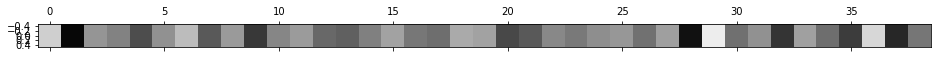

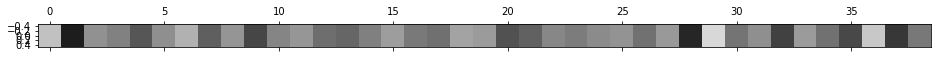

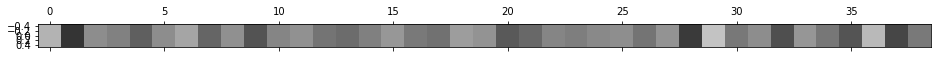

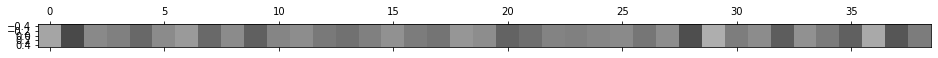

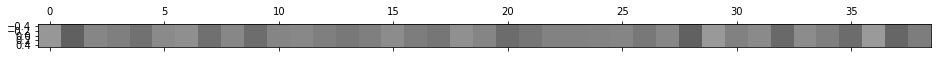

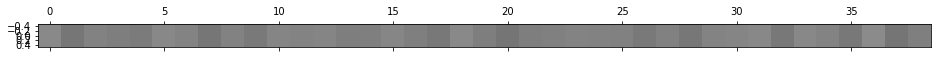

In [9]:
for l in lamb:    
    print (l)
    plt.matshow(net[0].mean(lambda_encode(l)).detach().cpu().numpy().reshape(1, -1), cmap='gray', norm = plt.Normalize(vmin=-2, vmax=2) )

In [17]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device),
                     base_net.BaseLayer(hidden_num, 10, device, act=lambda x:x)).to(device)


hnet = var_net.VarNet(base_net.BaseKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma),
             base_net.BaseKernelLayer(hidden_num, 10,   kernel_num, act=lambda x:x, prior_sigma=prior_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'base_kernel_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam), mode='base')
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader), mode='base'))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_base_kernel.json'),'w') as out:
    out.write(json.dumps(lam_results))  

tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


(0, 1)

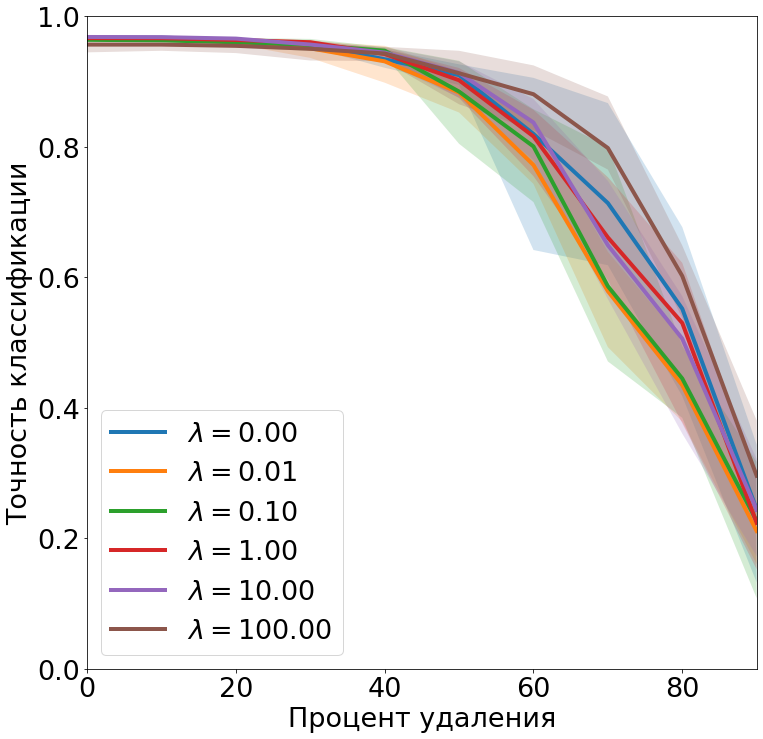

In [18]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Kernel_base')
plt.ylim(0,1)
#plt.show()


In [11]:
utils.test_acc_hyper(hnet, device, test_loader, lambda_encode, [lamb[0.0]])

TypeError: can only concatenate list (not "float") to list